In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

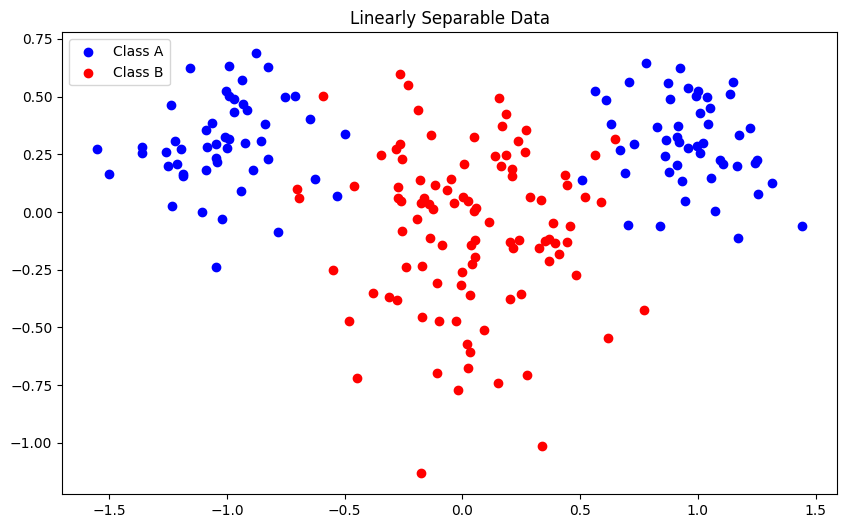

In [ ]:
def generate_nonseparable_data(n=100):
    """Generate non-linearly separable data as specified in the assignment"""
    mA = [1.0, 0.3]
    sigmaA = 0.2
    mB = [0.0, -0.1]
    sigmaB = 0.3

    # Generate class A with two clusters
    classA = np.zeros((2, n))
    half_n = round(0.5 * n)
    classA[0, :half_n] = np.random.randn(half_n) * sigmaA - mA[0]
    classA[0, half_n:] = np.random.randn(n - half_n) * sigmaA + mA[0]
    classA[1, :] = np.random.randn(n) * sigmaA + mA[1]

    # Generate class B
    classB = np.zeros((2, n))
    classB[0, :] = np.random.randn(n) * sigmaB + mB[0]
    classB[1, :] = np.random.randn(n) * sigmaB + mB[1]

    X = np.hstack((classA, classB))
    y = np.hstack((np.ones(n), np.zeros(n)))
    return X, y

X, y = generate_nonseparable_data()
plt.figure(figsize=(10, 6))
plt.scatter(X[0, y == 1], X[1, y == 1], c='b', label='Class A')
plt.scatter(X[0, y == 0], X[1, y == 0], c='r', label='Class B')
plt.title("Linearly Separable Data")
plt.legend()
plt.show()
X = X.T

In [ ]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size=1, learning_rate=0.01, alpha = 0.9):
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1/input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1/hidden_size)
        self.b2 = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.alpha = alpha

        self.delta_W1 = np.zeros_like(self.W1)
        self.delta_b1 = np.zeros_like(self.b1)
        self.delta_W2 = np.zeros_like(self.W2)
        self.delta_b2 = np.zeros_like(self.b2)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, a):
        return a * (1 - a)

    def forward(self, x):
        # Forward propagation
        Z1 = x @ self.W1 + self.b1
        self.A1 = self.sigmoid(Z1)
        Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = self.sigmoid(Z2)
        return self.A2

    def pred(self, x):
        # Forward propagation
        Z1 = x @ self.W1 + self.b1
        A1 = self.sigmoid(Z1)
        Z2 = A1 @ self.W2 + self.b2
        A2 = self.sigmoid(Z2)
        return A2

    def backward(self, x_batch, y_batch):
        # Backward propagation
        m = y_batch.shape[0]
        # Calculate gradients
        output_error = self.A2 - y_batch
        output_delta = output_error * self.sigmoid_derivative(self.A2)
        hidden_error = output_delta.dot(self.W2.T)
        hidden_delta = hidden_error * self.sigmoid_derivative(self.A1)

        # Update weights and biases
        self.delta_W2 = self.alpha*self.delta_W2 - (1-self.alpha) * self.A1.T.dot(output_delta)/m
        self.delta_b2 = self.alpha*self.delta_b2 - (1-self.alpha) * np.mean(output_delta, axis=0, keepdims=True)
        self.delta_W1 = self.alpha*self.delta_W1 - (1-self.alpha) * x_batch.T.dot(hidden_delta)/m
        self.delta_b1 = self.alpha*self.delta_b1 - (1-self.alpha) * np.mean(hidden_delta, axis=0, keepdims=True)
        self.W2 += self.learning_rate * self.delta_W2
        self.b2 += self.learning_rate * self.delta_b2
        self.W1 += self.learning_rate * self.delta_W1
        self.b1 += self.learning_rate * self.delta_b1

    def train(self, train_X, train_y, epochs=101, batch_size=1, vali_X=None, vali_y=None, print_log=False):
        num_samples = train_X.shape[0]
        error_rate = []
        loss = []
        if vali_X is not None and vali_y is not None:
            use_validation = True
            vali_loss = []
            vali_error_rate = []
        else:
            use_validation = False
        for epoch in range(epochs):
            # Shuffle the data at the beginning of each epoch
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            X_shuffled = train_X[indices]
            y_shuffled = train_y[indices]

            for start in range(0, num_samples, batch_size):
                end = start + batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                # Forward and backward pass for the batch
                output = self.forward(X_batch)
                self.backward(X_batch, y_batch)

            # Compute and print loss every 10 epochs
            if epoch % 10 == 0:
                y_pred = self.pred(train_X)  # Evaluate on the full dataset
                batch_loss = np.mean((y_pred - train_y) ** 2)
                y_pred_binary = (y_pred >= 0.5).astype(int)
                batch_error = np.mean(y_pred_binary != train_y)
                loss.append(batch_loss)
                error_rate.append(batch_error)

                if use_validation:
                  y_pred = self.pred(vali_X)
                  batch_loss = np.mean((y_pred - vali_y) ** 2)
                  y_pred_binary = (y_pred >= 0.5).astype(int)
                  batch_error = np.mean(y_pred_binary != vali_y)
                  vali_loss.append(batch_loss)
                  vali_error_rate.append(batch_error)

                if print_log:
                  print(f'Epoch {epoch}, Loss: {batch_loss:.4f}, Error_rate: {batch_error:.4f}')

        if use_validation:
          return loss, error_rate, vali_loss, vali_error_rate
        else:
          return loss, error_rate

In [ ]:
# Initialize the MLP
hidden_nodes = 8
mlp = MLP(input_size=X.shape[1], hidden_size=hidden_nodes, learning_rate=0.5)
# Train the model
loss, error_rate = mlp.train(X, y.reshape(-1,1), epochs=161, batch_size=10, print_log=True)

Epoch 0, Loss: 0.2412, Error_rate: 0.5000
Epoch 10, Loss: 0.2159, Error_rate: 0.2150
Epoch 20, Loss: 0.1930, Error_rate: 0.2250
Epoch 30, Loss: 0.1780, Error_rate: 0.2300
Epoch 40, Loss: 0.1696, Error_rate: 0.2150
Epoch 50, Loss: 0.1645, Error_rate: 0.2150
Epoch 60, Loss: 0.1608, Error_rate: 0.2150
Epoch 70, Loss: 0.1565, Error_rate: 0.2050
Epoch 80, Loss: 0.1507, Error_rate: 0.2000
Epoch 90, Loss: 0.1419, Error_rate: 0.1900
Epoch 100, Loss: 0.1294, Error_rate: 0.1650
Epoch 110, Loss: 0.1138, Error_rate: 0.1600
Epoch 120, Loss: 0.0971, Error_rate: 0.1300
Epoch 130, Loss: 0.0815, Error_rate: 0.0950
Epoch 140, Loss: 0.0687, Error_rate: 0.0750
Epoch 150, Loss: 0.0590, Error_rate: 0.0650
Epoch 160, Loss: 0.0518, Error_rate: 0.0450


In [ ]:
# Initialize the MLP
hidden_nodes = 16
mlp = MLP(input_size=X.shape[1], hidden_size=hidden_nodes, learning_rate=0.5)
# Train the model
loss, error_rate = mlp.train(X, y.reshape(-1,1), epochs=161, batch_size=10, print_log=True)

Epoch 0, Loss: 0.2506, Error_rate: 0.5200
Epoch 10, Loss: 0.2143, Error_rate: 0.2550
Epoch 20, Loss: 0.1871, Error_rate: 0.2200
Epoch 30, Loss: 0.1694, Error_rate: 0.2150
Epoch 40, Loss: 0.1564, Error_rate: 0.2050
Epoch 50, Loss: 0.1428, Error_rate: 0.1850
Epoch 60, Loss: 0.1261, Error_rate: 0.1600
Epoch 70, Loss: 0.1061, Error_rate: 0.1250
Epoch 80, Loss: 0.0869, Error_rate: 0.0850
Epoch 90, Loss: 0.0708, Error_rate: 0.0700
Epoch 100, Loss: 0.0589, Error_rate: 0.0600
Epoch 110, Loss: 0.0505, Error_rate: 0.0500
Epoch 120, Loss: 0.0447, Error_rate: 0.0500
Epoch 130, Loss: 0.0407, Error_rate: 0.0500
Epoch 140, Loss: 0.0380, Error_rate: 0.0450
Epoch 150, Loss: 0.0356, Error_rate: 0.0500
Epoch 160, Loss: 0.0340, Error_rate: 0.0450


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_loss_and_error_rate_vs_hidden_nodes(train_X, train_y, hidden_node_configs, vali_X=None, vali_y=None, epochs=161, batch_size=10, learning_rate=0.5):
    """
    Train the MLP with different numbers of hidden nodes and plot the loss and error rate over epochs.

    Args:
        X: Input features.
        y: Target labels.
        hidden_node_configs: List of numbers of hidden nodes to test.
        vali_X: Validation input features (optional).
        vali_y: Validation target labels (optional).
        epochs: Number of training epochs.
        batch_size: Batch size for training.
        learning_rate: Learning rate for the MLP.
    """
    loss_curves = {}  # Store training loss values for each hidden node configuration
    error_rate_curves = {}  # Store training error rates for each hidden node configuration
    vali_loss_curves = {}  # Store validation loss values for each hidden node configuration
    vali_error_rate_curves = {}  # Store validation error rates for each hidden node configuration

    use_validation = vali_X is not None and vali_y is not None

    for hidden_nodes in hidden_node_configs:
        # Initialize the MLP for the current hidden node configuration
        mlp = MLP(input_size=train_X.shape[1], hidden_size=hidden_nodes, learning_rate=learning_rate)
        # Train the model and retrieve losses and error rates
        if use_validation:
            losses, error_rates, vali_losses, vali_error_rates = mlp.train(train_X, train_y, vali_X=vali_X, vali_y=vali_y, epochs=epochs, batch_size=batch_size)
        else:
            losses, error_rates = mlp.train(train_X, train_y, epochs=epochs, batch_size=batch_size)

        # Store the loss and error rate curves
        loss_curves[hidden_nodes] = losses
        error_rate_curves[hidden_nodes] = error_rates

        if use_validation:
            vali_loss_curves[hidden_nodes] = vali_losses
            vali_error_rate_curves[hidden_nodes] = vali_error_rates

    # Create subplots for training loss/error rate and validation loss/error rate
    fig, axs = plt.subplots(4 if use_validation else 2, 1, figsize=(10, 18))

    # Plot training loss curves
    for hidden_nodes, losses in loss_curves.items():
        axs[0].plot(losses, label=f'{hidden_nodes} Hidden Nodes')

    axs[0].set_title('Training Loss vs. Epochs for Different Hidden Node Configurations')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    # Plot training error rate curves
    for hidden_nodes, error_rates in error_rate_curves.items():
        axs[1].plot(error_rates, label=f'{hidden_nodes} Hidden Nodes')

    axs[1].set_title('Training Error Rate vs. Epochs for Different Hidden Node Configurations')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Error Rate')
    axs[1].legend()
    axs[1].grid()

    if use_validation:
        # Plot validation loss curves
        for hidden_nodes, vali_losses in vali_loss_curves.items():
            axs[2].plot(vali_losses, label=f'{hidden_nodes} Hidden Nodes')

        axs[2].set_title('Validation Loss vs. Epochs for Different Hidden Node Configurations')
        axs[2].set_xlabel('Epochs')
        axs[2].set_ylabel('Loss')
        axs[2].legend()
        axs[2].grid()

        # Plot validation error rate curves
        for hidden_nodes, vali_error_rates in vali_error_rate_curves.items():
            axs[3].plot(vali_error_rates, label=f'{hidden_nodes} Hidden Nodes')

        axs[3].set_title('Validation Error Rate vs. Epochs for Different Hidden Node Configurations')
        axs[3].set_xlabel('Epochs')
        axs[3].set_ylabel('Error Rate')
        axs[3].legend()
        axs[3].grid()

    plt.tight_layout()
    plt.show()

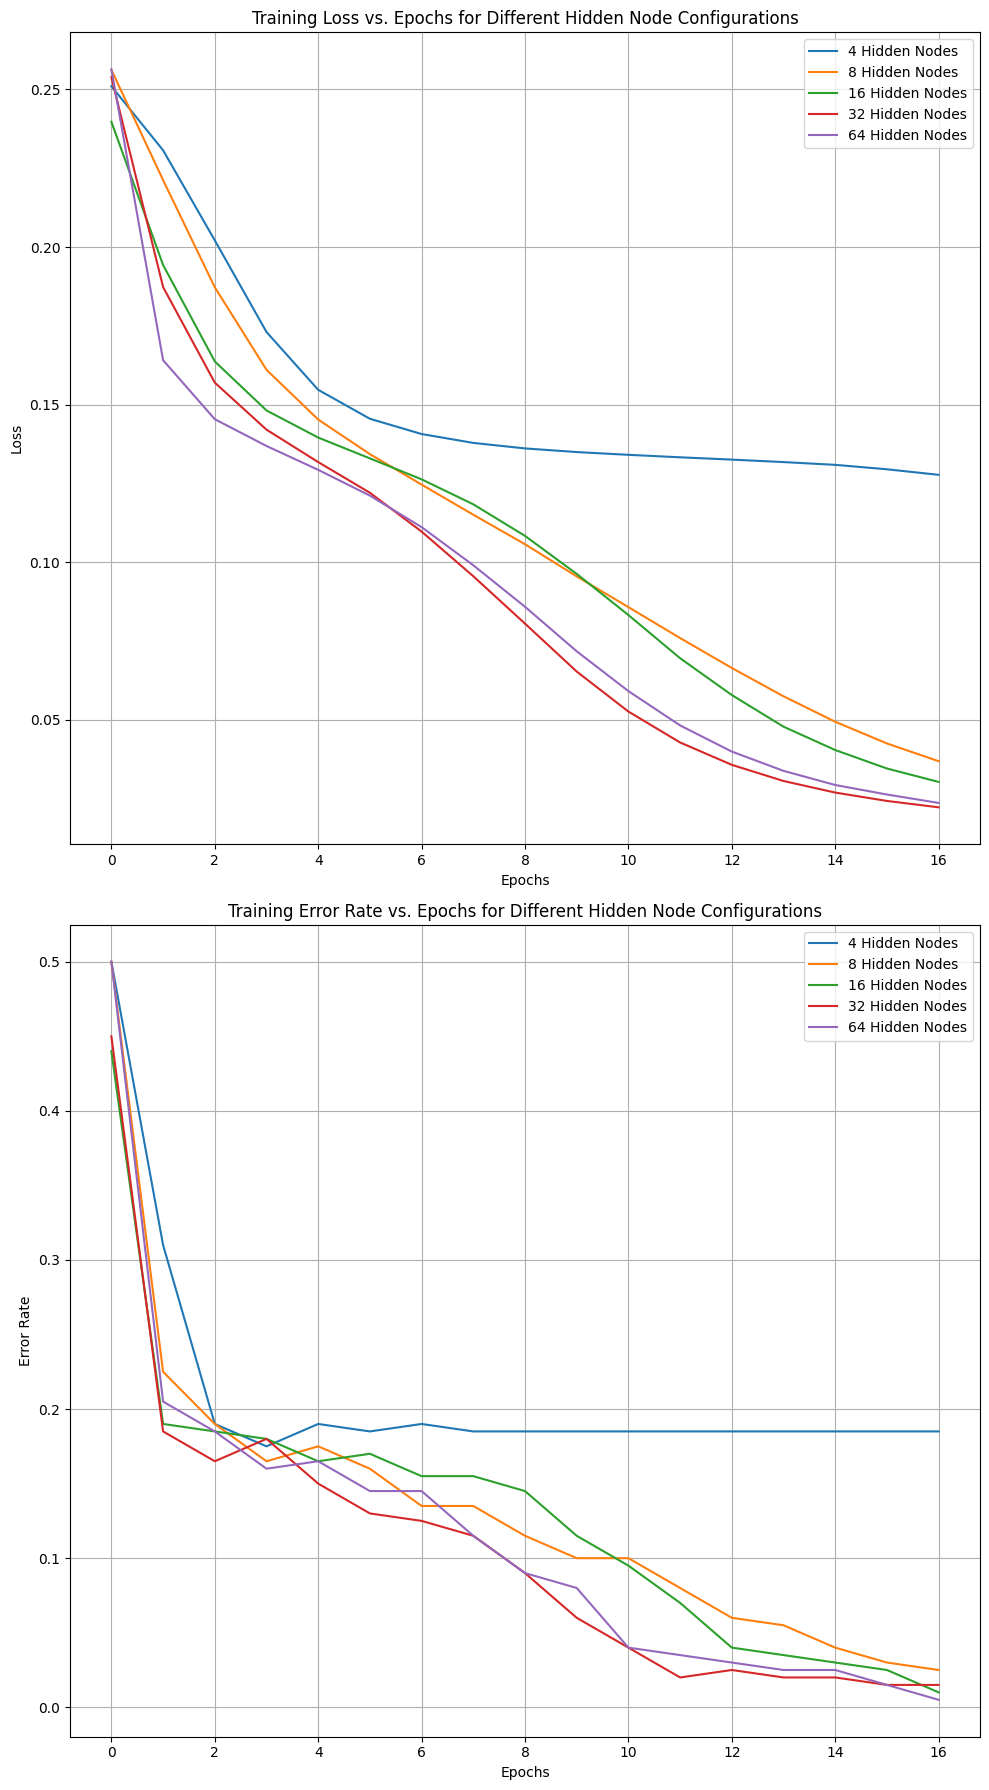

In [ ]:
hidden_node_configs = [4, 8, 16, 32, 64]  # Try 4, 8, 16, and 32 hidden nodes
plot_loss_and_error_rate_vs_hidden_nodes(X, y.reshape(-1, 1), hidden_node_configs)

In [ ]:
def random_subset(X, y, percentage_per_class=0.25):
    """Subsample a random percentage from each class for validation."""
    classes = np.unique(y)
    train_idx = []
    val_idx = []

    for cls in classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        split_idx = int(len(idx) * percentage_per_class)
        val_idx.extend(idx[:split_idx])
        train_idx.extend(idx[split_idx:])

    return X[train_idx], y[train_idx], X[val_idx], y[val_idx]


def subset_classA(X, y, percentage_neg, percentage_pos):
    """Subsample class A with 20%-80% split based on X[:, 0] and include all y=0 in the training set."""
    idx_classA = np.where(y == 1)[0]  # Indices where y == 1
    idx_classB = np.where(y == 0)[0]  # Indices where y == 0

    # Split class A into two subsets
    idx_neg = idx_classA[X[idx_classA][:, 0] < 0]
    idx_pos = idx_classA[X[idx_classA][:, 0] > 0]

    # Shuffle indices
    np.random.shuffle(idx_neg)
    np.random.shuffle(idx_pos)

    # Subsample validation set
    split_neg = int(len(idx_neg) * percentage_neg)
    split_pos = int(len(idx_pos) * percentage_pos)

    val_idx = np.concatenate([idx_neg[:split_neg], idx_pos[:split_pos]])
    train_idx_A = np.setdiff1d(idx_classA, val_idx)  # Remaining class A samples

    # Combine training indices: all class B + remaining class A
    train_idx = np.concatenate([train_idx_A, idx_classB])

    return X[train_idx], y[train_idx], X[val_idx], y[val_idx]

In [ ]:
# Scenario 1: Random 25% from each class
X_train_1, y_train_1, X_val_1, y_val_1 = random_subset(X, y, 0.25)

# Scenario 2: Random 50% from class A
X_train_2, y_train_2, X_val_2, y_val_2 = subset_classA(X, y, 0.5, 0.5)

# Scenario 3: 20%-80% subset from class A
X_train_3, y_train_3, X_val_3, y_val_3 = subset_classA(X, y, 0.2, 0.8)

Scenario 1: Random 25% from each class
Train size: 150, Validation size: 50


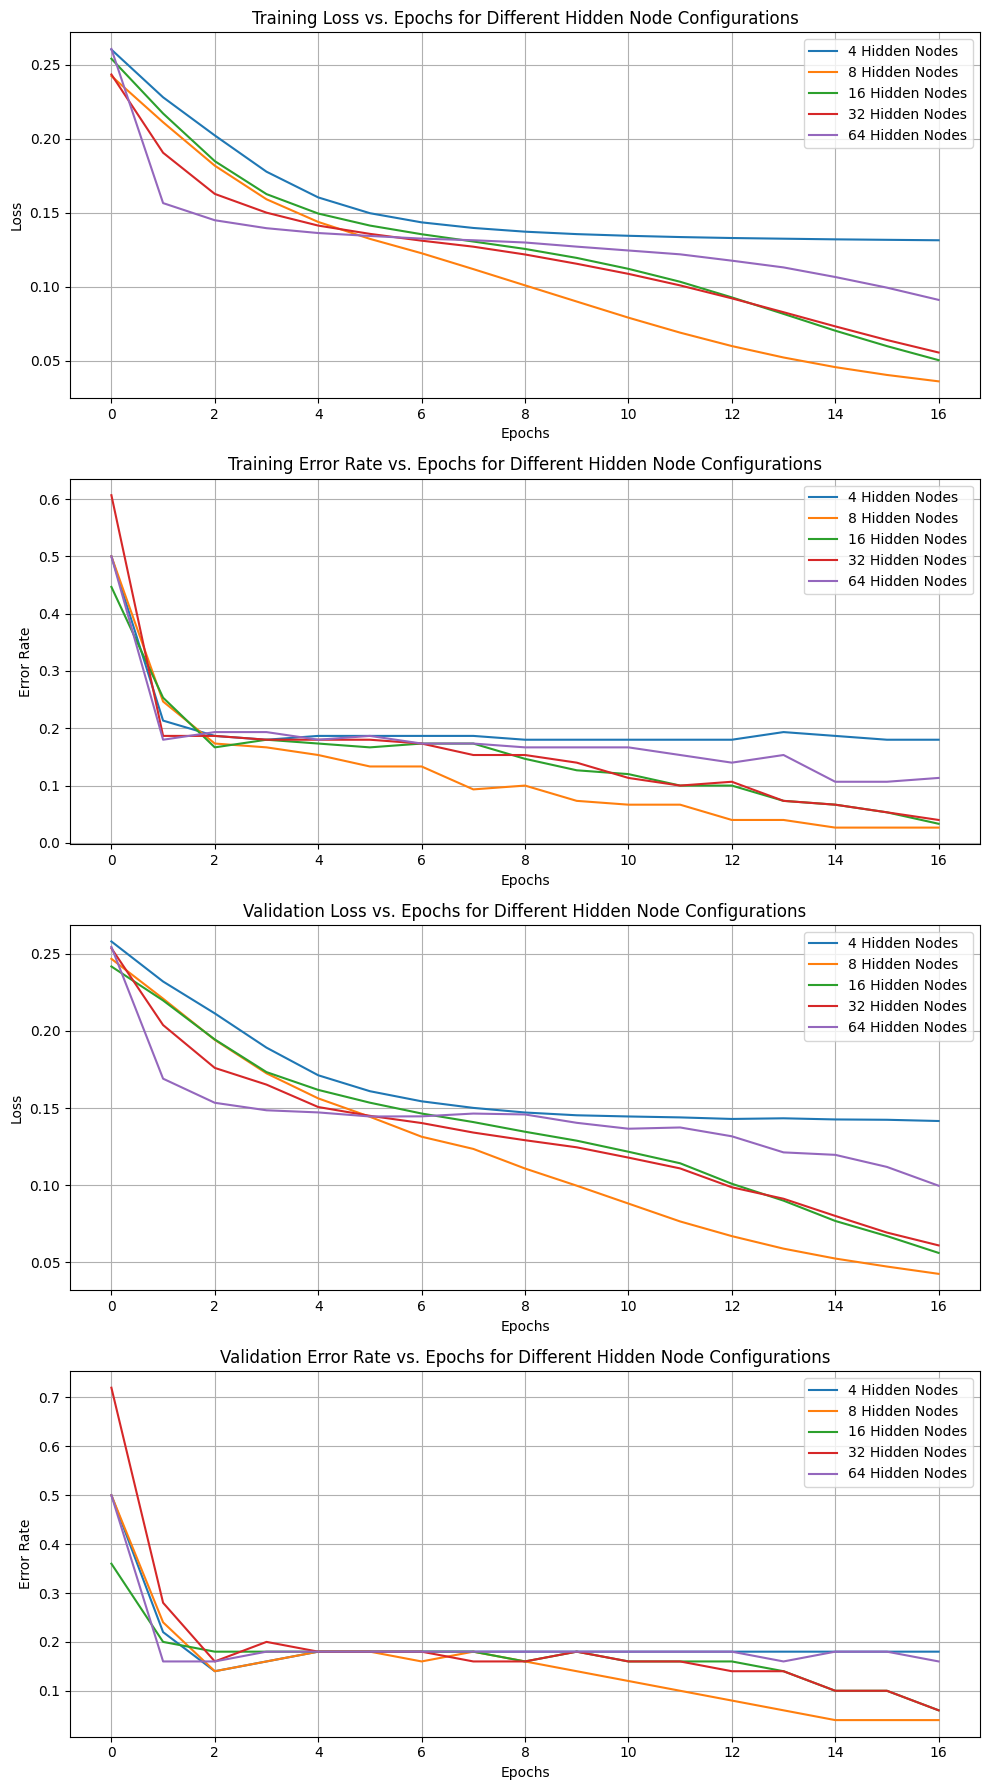

In [ ]:
print("Scenario 1: Random 25% from each class")
print(f"Train size: {len(y_train_1)}, Validation size: {len(y_val_1)}")
plot_loss_and_error_rate_vs_hidden_nodes(X_train_1, y_train_1.reshape(-1, 1), hidden_node_configs, X_val_1, y_val_1.reshape(-1, 1))

Scenario 2: Random 50% from class A
Train size: 150, Validation size: 50


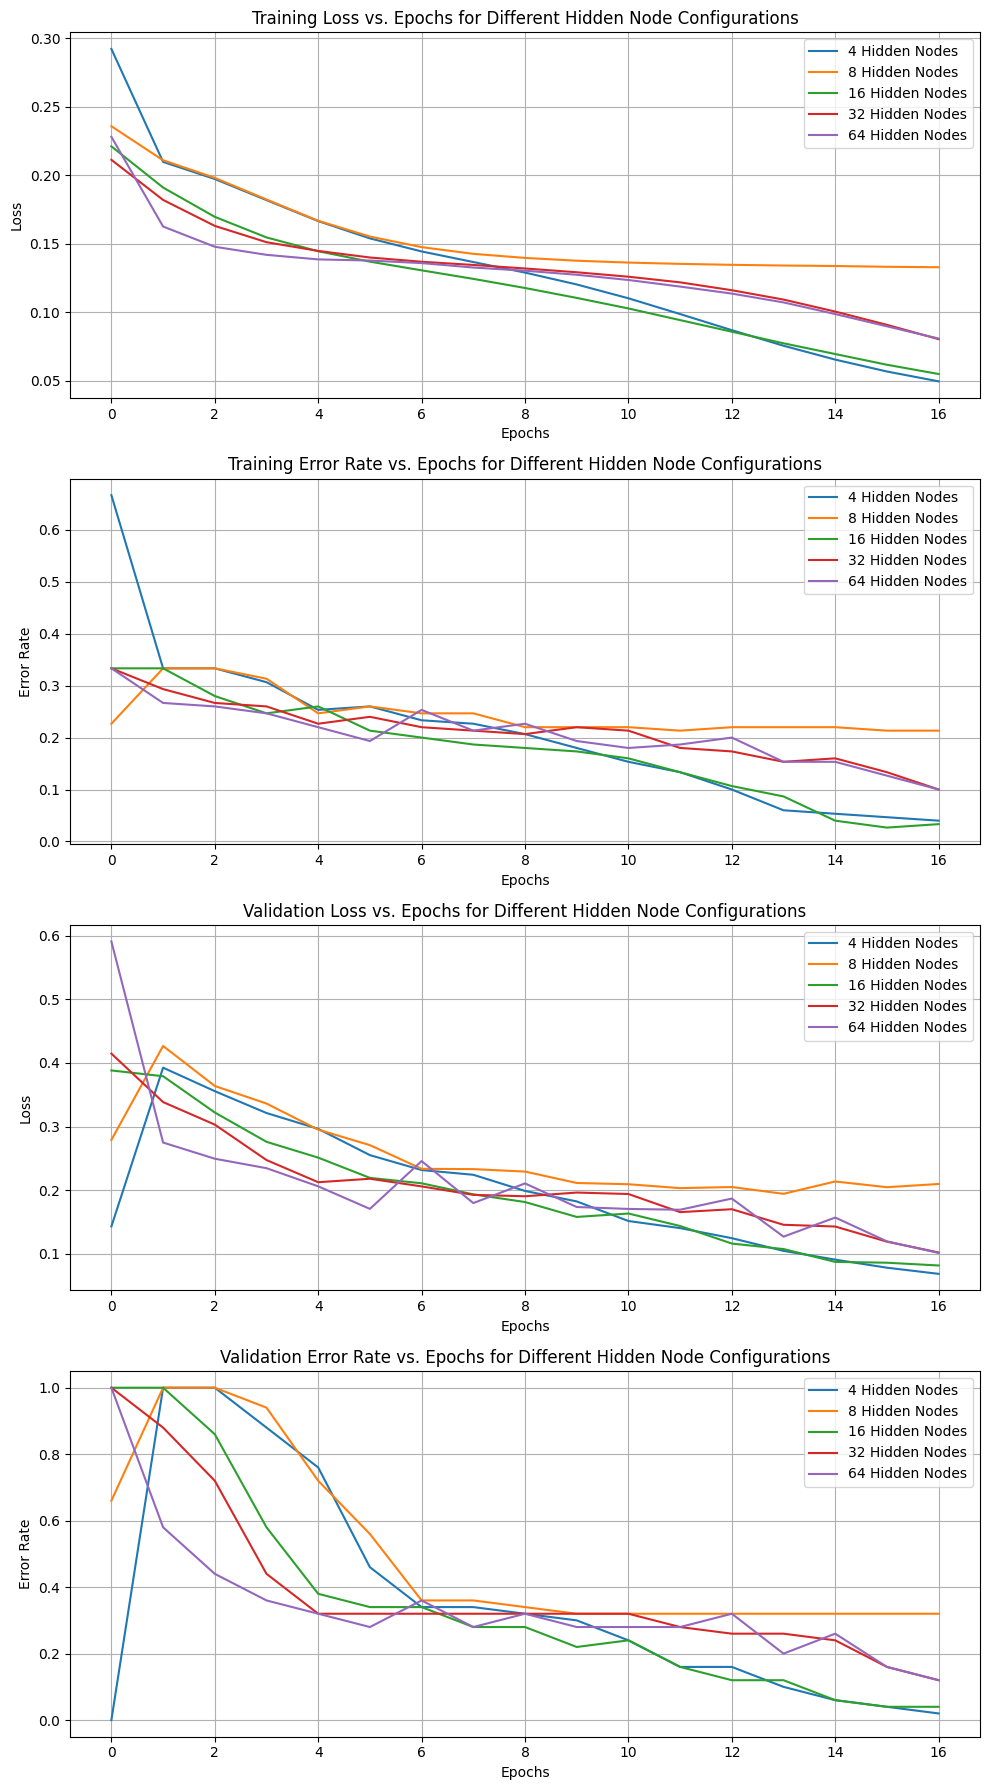

In [ ]:
print("Scenario 2: Random 50% from class A")
print(f"Train size: {len(y_train_2)}, Validation size: {len(y_val_2)}")
plot_loss_and_error_rate_vs_hidden_nodes(X_train_2, y_train_2.reshape(-1, 1), hidden_node_configs, X_val_2, y_val_2.reshape(-1, 1))

Scenario 3: 20%-80% split for class A subsets
Train size: 150, Validation size: 50


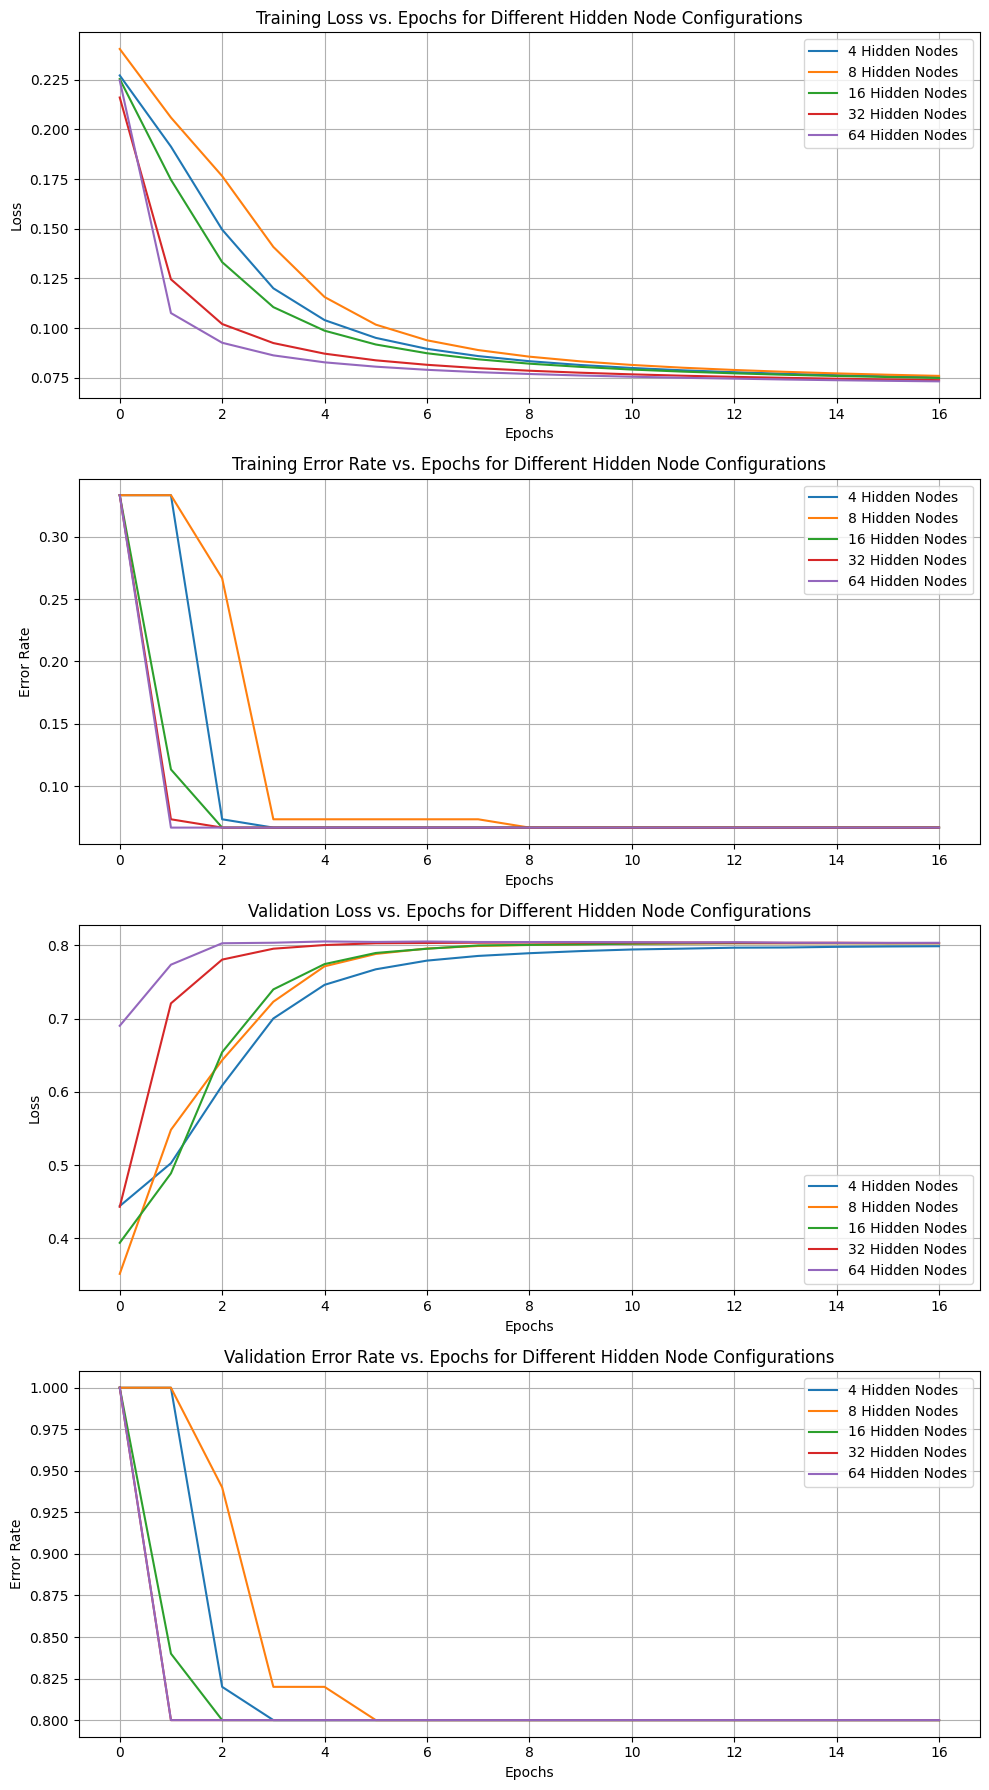

In [ ]:
print("Scenario 3: 20%-80% split for class A subsets")
print(f"Train size: {len(y_train_3)}, Validation size: {len(y_val_3)}")
plot_loss_and_error_rate_vs_hidden_nodes(X_train_3, y_train_3.reshape(-1, 1), hidden_node_configs, X_val_3, y_val_3.reshape(-1, 1))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def approximate_decision_boundary(train_x, train_y, vali_X, vali_y, num_hidden_nodes=6, epochs=241, batch_size=10, learning_rate=0.5):
    """
    Train an MLP and approximate the decision boundary by sampling points in the defined range.

    Args:
        train_x: Training input features.
        train_y: Training target labels.
        vali_X: Validation input features.
        vali_y: Validation target labels.
        num_hidden_nodes: Number of hidden nodes in the MLP.
        epochs: Number of training epochs.
        batch_size: Batch size for training.
        learning_rate: Learning rate for the MLP.
    """
    # Initialize and train the MLP
    mlp = MLP(input_size=train_x.shape[-1], hidden_size=num_hidden_nodes, learning_rate=learning_rate)
    mlp.train(train_x, train_y, epochs=epochs, batch_size=batch_size, vali_X=vali_X, vali_y=vali_y)

    # Define the boundary sampling range
    x_range = np.linspace(-1.5, 1.5, num=100)
    y_range = np.linspace(-0.75, 0.75, num=100)

    # Create a meshgrid to sample points
    xx, yy = np.meshgrid(x_range, y_range)
    grid = np.c_[xx.ravel(), yy.ravel()]  # Make a feature matrix

    # Get predictions for the grid points
    predictions = mlp.pred(grid)  # Use the pred method to get model predictions

    # Reshape predictions to match the grid shape
    predictions = predictions.reshape(xx.shape)

    # Plot decision boundary
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, predictions, levels=np.linspace(0, 1, 100), cmap='Spectral', alpha=0.8)
    plt.colorbar(label='Prediction Probability')

    train_y = train_y.flatten()
    # Mark the decision boundary where predictions are close to 0.5
    plt.contour(xx, yy, predictions, levels=[0.5], colors='k', linewidths=1)

    # Plot the training data points with a deeper color
    plt.scatter(train_x[train_y == 1, 0], train_x[train_y == 1, 1],
                label='Training Class 1', color='blue', alpha=0.9)
    plt.scatter(train_x[train_y == 0, 0], train_x[train_y == 0, 1],
                label='Training Class -1', color='orange', alpha=0.9)

    vali_y = vali_y.flatten()
    # Plot the validation data points with a lighter color
    plt.scatter(vali_X[vali_y == 1, 0], vali_X[vali_y == 1, 1],
                label='Validation Class 1', color='lightblue', alpha=0.6)
    plt.scatter(vali_X[vali_y == 0, 0], vali_X[vali_y == 0, 1],
                label='Validation Class -1', color='lightcoral', alpha=0.6)

    plt.title('Decision Boundary Approximation of MLP')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid()
    plt.show()

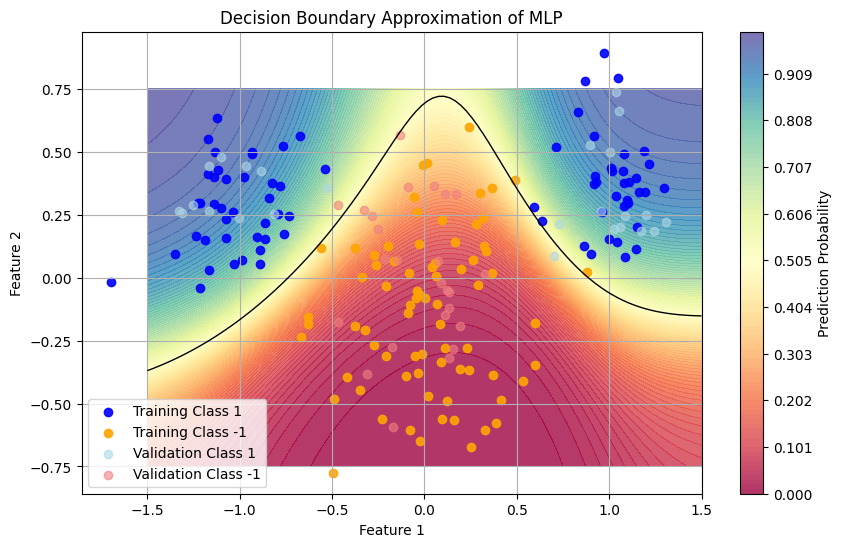

In [ ]:
approximate_decision_boundary(X_train_1, y_train_1.reshape(-1, 1), X_val_1, y_val_1.reshape(-1, 1))

3.1.2. We get the point of the task: the 3-D representation of the 8-D one-hot should be ideally located on the vertex of a cube.

In [ ]:
# no bias
class AutoEncoder:
    def __init__(self, input_size, hidden_size, output_size=1, learning_rate=0.01, alpha = 0.9):
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1/input_size)
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1/hidden_size)
        self.learning_rate = learning_rate
        self.alpha = alpha

        self.delta_W1 = np.zeros_like(self.W1)
        self.delta_W2 = np.zeros_like(self.W2)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, a):
        return a * (1 - a)

    def forward(self, x):
        # Forward propagation
        Z1 = x @ self.W1
        self.A1 = self.sigmoid(Z1)
        Z2 = self.A1 @ self.W2
        self.A2 = self.sigmoid(Z2)
        return self.A2

    def pred(self, x):
        # Forward propagation
        Z1 = x @ self.W1
        A1 = self.sigmoid(Z1)
        Z2 = A1 @ self.W2
        A2 = self.sigmoid(Z2)
        return A2

    def backward(self, x_batch, y_batch):
        # Backward propagation
        m = y_batch.shape[0]
        # Calculate gradients
        output_error = self.A2 - y_batch
        output_delta = output_error * self.sigmoid_derivative(self.A2)
        hidden_error = output_delta.dot(self.W2.T)
        hidden_delta = hidden_error * self.sigmoid_derivative(self.A1)

        # Update weights and biases
        self.delta_W2 = self.alpha*self.delta_W2 - (1-self.alpha) * self.A1.T.dot(output_delta)/m
        self.delta_W1 = self.alpha*self.delta_W1 - (1-self.alpha) * x_batch.T.dot(hidden_delta)/m
        self.W2 += self.learning_rate * self.delta_W2
        self.W1 += self.learning_rate * self.delta_W1

    def train(self, train_X, train_y, epochs=101, batch_size=1, print_log=False):
        num_samples = train_X.shape[0]
        error_rate = []
        loss = []
        for epoch in range(epochs):
            # Shuffle the data at the beginning of each epoch
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            X_shuffled = train_X[indices]
            y_shuffled = train_y[indices]

            for start in range(0, num_samples, batch_size):
                end = start + batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                # Forward and backward pass for the batch
                output = self.forward(X_batch)
                self.backward(X_batch, y_batch)

            # Compute and print loss every 10 epochs
            if epoch % 100 == 0:
                y_pred = self.pred(train_X)  # Evaluate on the full dataset
                batch_loss = np.mean((y_pred - train_y) ** 2)
                y_pred_binary = (y_pred >= 0.5).astype(int)
                batch_error = np.mean(y_pred_binary != train_y)
                loss.append(batch_loss)
                error_rate.append(batch_error)

                if print_log:
                  print(f'Epoch {epoch}, Loss: {batch_loss:.4f}, Error_rate: {batch_error:.4f}')

        return loss, error_rate

In [ ]:
patterns = np.eye(8) # Create the patterns using one-of-n coding
targets = patterns  # Targets should be identical to inputs

#def __init__(self, input_size, hidden_size, output_size=1, learning_rate=0.01, alpha = 0.9):
#def train(self, train_X, train_y, epochs=101, batch_size=1, vali_X=None, vali_y=None, print_log=False):
# Initialize the Autoencoder
error = 1
autoencoder = None
while error > 0.016:
  autoencoder = AutoEncoder(input_size=8, hidden_size=3, output_size=8, learning_rate=1, alpha = 0)
  _, errors = autoencoder.train(patterns, targets, epochs=2501, batch_size=1)
  error = errors[-1]
  print(error)

0.03125
0.03125
0.03125
0.015625


In [ ]:
emb = autoencoder.sigmoid(patterns@autoencoder.W1)
# usually, there is a missing point, [1,1,1]
print((autoencoder.W1 > 0).astype(int))
print((autoencoder.pred(patterns) > 0.5).astype(int))
missing_emb = np.array([[1,1,1]])
missing_recon = autoencoder.sigmoid(missing_emb @ autoencoder.W2)
print((missing_recon > 0.5).astype(int))

import plotly.graph_objects as go
# Generate data
x = emb[:,0]
y = emb[:,1]
z = emb[:,2]
# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(size=5, color='blue', opacity=0.8)
)])
# Set labels
fig.update_layout(scene=dict(
    xaxis_title='X Label',
    yaxis_title='Y Label',
    zaxis_title='Z Label'),
    title='3D Scatter Plot')
# Show plot
fig.show()

[[1 0 1]
 [1 0 0]
 [0 1 0]
 [1 1 0]
 [1 0 1]
 [0 0 1]
 [0 0 0]
 [0 1 1]]
[[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
[[0 0 0 0 0 0 0 0]]


0.09375
[[-2.01728759 -0.64903392]
 [-2.01729302 -0.64902605]
 [-0.64021896 -2.0819333 ]
 [-0.64017506 -2.08196738]
 [-0.640512   -2.08170574]
 [ 5.98278499 -3.9420206 ]
 [-2.01729379 -0.64902492]
 [-3.23483384  5.98311343]]
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]]


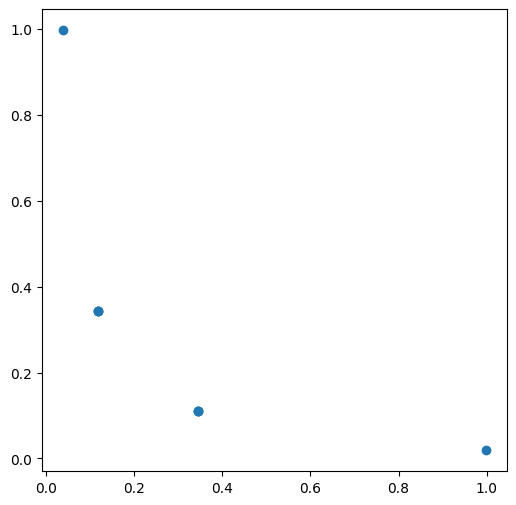

In [ ]:
error = 1
autoencoder2d = None
while error > 0.1:
  autoencoder2d = AutoEncoder(input_size=8, hidden_size=2, output_size=8, learning_rate=9, alpha = 0)
  _, errors = autoencoder2d.train(patterns, targets, epochs=2501, batch_size=8)
  error = errors[-1]
  print(error)

emb = autoencoder2d.sigmoid(patterns@autoencoder2d.W1)
# usually, there is a missing point, [1,1,1]
print(autoencoder2d.W1)
print((autoencoder2d.pred(patterns) > 0.5).astype(int))

x = emb[:,0]
y = emb[:,1]
plt.figure(figsize=(6, 6))
plt.scatter(x, y)
plt.show()

In [ ]:
# Create a grid of x and y values
x = np.arange(-5, 5.5, 0.5)
y = np.arange(-5, 5.5, 0.5)
xx, yy = np.meshgrid(x, y)

# Compute the Gaussian function values
z = np.exp(-(xx**2 + yy**2) / 10)

# Flatten z for training
targets = z.flatten()
ndata = len(targets)  # Number of data points
print("Number of data points:", ndata)

# Flatten the grid for input features
patterns = np.vstack((xx.flatten(), yy.flatten())).T  # Shape (ndata, 2)

Number of data points: 441


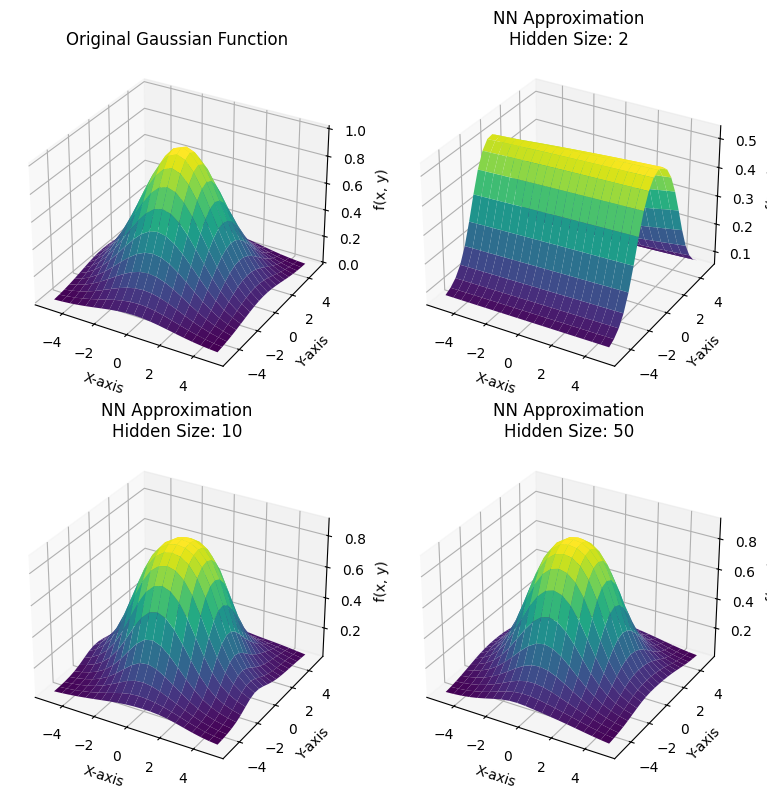

In [ ]:
# Create a grid of x and y values
x = np.arange(-5, 5.5, 0.5)
y = np.arange(-5, 5.5, 0.5)
xx, yy = np.meshgrid(x, y)

# Compute the Gaussian function values
z = np.exp(-(xx**2 + yy**2) / 10)

# Flatten z for training
targets = z.flatten()

# Flatten the grid for input features
patterns = np.vstack((xx.flatten(), yy.flatten())).T  # Shape (ndata, 2)

# Define hidden sizes to test
hidden_sizes = [2, 10, 50]

# Prepare the figure for plotting
fig = plt.figure(figsize=(8, 8))

# Plot the original Gaussian function
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.plot_surface(xx, yy, z, cmap='viridis', edgecolor='none')
ax1.set_title('Original Gaussian Function')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.set_zlabel('f(x, y)')

# Loop through hidden sizes and create subplots for MLP approximations
for i, hidden_size in enumerate(hidden_sizes):
    # Create the MLP model with different hidden layer sizes
    mlp = MLP(input_size=2, hidden_size=hidden_size, learning_rate=1)

    # Train the MLP
    loss, _ = mlp.train(patterns, targets.reshape(-1, 1), epochs=151, batch_size=10)

    # Make predictions on the entire grid
    predicted = mlp.pred(patterns)

    # Reshape predicted values back to the meshgrid shape
    zz = predicted.reshape(xx.shape)

    # Neural network approximation
    ax = fig.add_subplot(2, 2, i + 2, projection='3d')  # Change the subplot position (i + 2)
    ax.plot_surface(xx, yy, zz, cmap='viridis', edgecolor='none')
    ax.set_title(f'NN Approximation\nHidden Size: {hidden_size}')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('f(x, y)')

plt.tight_layout()
plt.show()

In the above figure notice when node=2 it gives a 2-D projection of 3-D Gaussian.

3.1.3.
2. For the selected ”best” model, run experiments with varying number of
the training samples, e.g. from 80% down to 20% of all the dataset.\\
We just skip this experiment, because its soo boring.
3. For the ”best” model, can you speed up the convergence without compro-
mising the generalisation performance?\\
We also skip this question. However we replace it by a self-motivated inquiry. In the senario of question 4, that is the performance of models under noise. In the next block we apply batch_size =1 and =10 respectfully to show batch processing can grow robustness under noise.
4. Notice that in the sequential processing setup, the point is to show that with stronger representive power, the model tends to overfit to the noise.

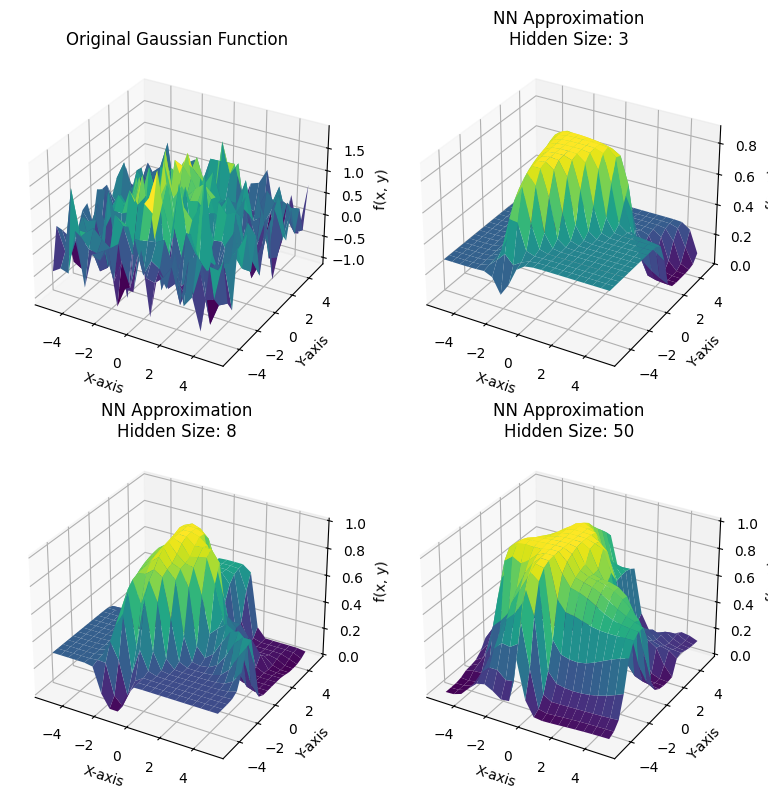

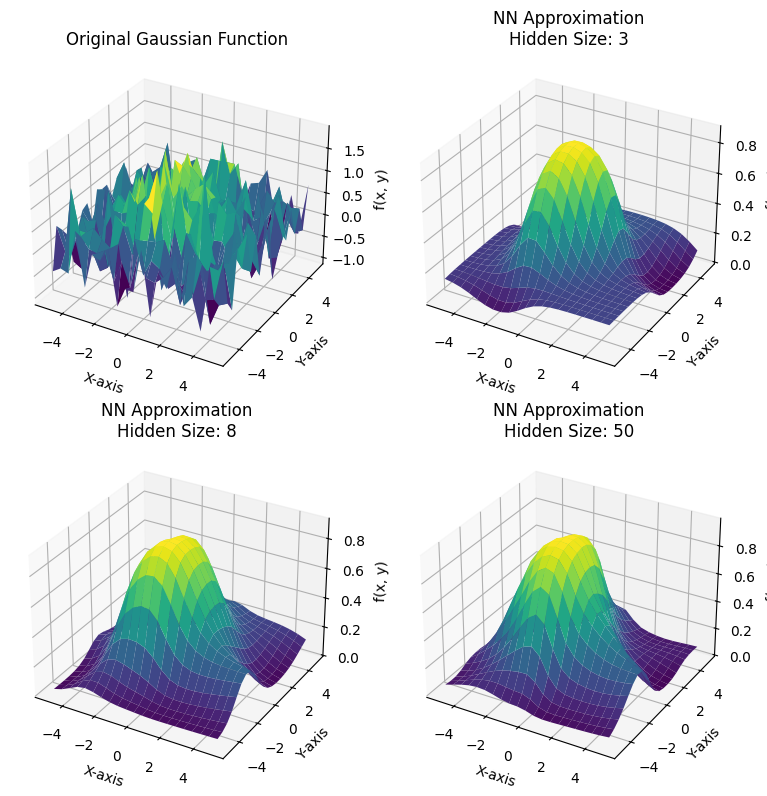

In [ ]:
# Define noise variance
noise_variance = 0.2  # You can change this value to see its effect
noise = np.random.normal(0, np.sqrt(noise_variance), z.shape)

# Add noise to the original function output
noisy_targets = z + noise
# Flatten the noisy targets for training
noisy_targets_flat = noisy_targets.flatten()

# Flatten the grid for input features
patterns = np.vstack((xx.flatten(), yy.flatten())).T  # Shape (ndata, 2)

# Define different hidden sizes to test
hidden_sizes = [3, 8, 50]

# Prepare the figure for plotting
fig = plt.figure(figsize=(8, 8))

# Plot the original Gaussian function
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.plot_surface(xx, yy, z+noise, cmap='viridis', edgecolor='none')
ax1.set_title('Original Gaussian Function')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.set_zlabel('f(x, y)')

for i, hidden_size in enumerate(hidden_sizes):
    # Create the MLP model with different hidden layer sizes
    mlp = MLP(input_size=2, hidden_size=hidden_size, learning_rate=1)

    # Train the MLP on the noisy targets
    loss, _ = mlp.train(patterns, noisy_targets_flat.reshape(-1, 1),
                        epochs=151, batch_size=1)

    # Make predictions on the entire grid
    predicted = mlp.pred(patterns)

    # Reshape predicted values back to the meshgrid shape
    zz = predicted.reshape(xx.shape)

    # Neural network approximation
    ax = fig.add_subplot(2, 2, i + 2, projection='3d')
    ax.plot_surface(xx, yy, zz, cmap='viridis', edgecolor='none')
    ax.set_title(f'NN Approximation\nHidden Size: {hidden_size}')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('f(x, y)')

plt.tight_layout()
plt.show()


# Prepare the figure for plotting
fig = plt.figure(figsize=(8, 8))

# Plot the original Gaussian function
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.plot_surface(xx, yy, z+noise, cmap='viridis', edgecolor='none')
ax1.set_title('Original Gaussian Function')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.set_zlabel('f(x, y)')

for i, hidden_size in enumerate(hidden_sizes):
    # Create the MLP model with different hidden layer sizes
    mlp = MLP(input_size=2, hidden_size=hidden_size, learning_rate=1)

    # Train the MLP on the noisy targets
    loss, _ = mlp.train(patterns, noisy_targets_flat.reshape(-1, 1),
                        epochs=151, batch_size=10)

    # Make predictions on the entire grid
    predicted = mlp.pred(patterns)

    # Reshape predicted values back to the meshgrid shape
    zz = predicted.reshape(xx.shape)

    # Neural network approximation
    ax = fig.add_subplot(2, 2, i + 2, projection='3d')
    ax.plot_surface(xx, yy, zz, cmap='viridis', edgecolor='none')
    ax.set_title(f'NN Approximation\nHidden Size: {hidden_size}')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('f(x, y)')

plt.tight_layout()
plt.show()

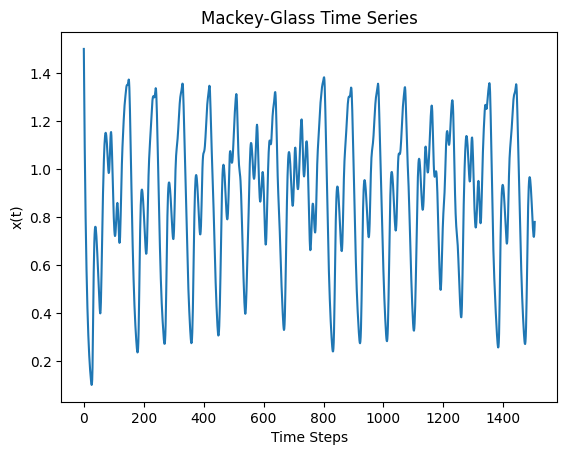

In [ ]:
# Mackey-Glass parameters
beta = 0.2
gamma = 0.1
n = 10
tau = 25
num_points = 1505  # Total time steps to generate

# Initialize the time series array and initial condition
x = np.zeros(num_points+1)
x[0] = 1.5  # Initial condition

# Generate the time series using Euler's method
for t in range(0, num_points):
    if t - tau >= 0:
      x_history = x[t-tau]
    else:
      x_history = 0
    x[t+1] = x[t] + beta*x_history / (1 + x_history**n) - 0.1*x[t]

# Plotting the generated Mackey-Glass time series
plt.plot(x)
plt.title('Mackey-Glass Time Series')
plt.xlabel('Time Steps')
plt.ylabel('x(t)')
plt.show()

In [ ]:
# Define the timesteps used to create the input-output pairs
t = np.arange(301, 1501)  # From t=301 to t=1500

# Prepare inputs and outputs
inputs = np.array([x[t - 20], x[t - 15], x[t - 10], x[t - 5], x[t]]).T  # Shape (1200, 5)
outputs = x[t + 5]  # Shape (1200,)

# Split the data into training, validation, and test sets
train_size = 800  # Number of samples for training
vali_size = 200    # Number of samples for validation
test_size = 200    # Number of samples for testing

# Create training, validation, and testing datasets
X_train = inputs[:train_size]
y_train = outputs[:train_size]

X_vali = inputs[train_size:train_size + vali_size]
y_vali = outputs[train_size:train_size + vali_size]

X_test = inputs[train_size + vali_size:]
y_test = outputs[train_size + vali_size:]

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Hyperparameters
learning_rate = 0.05
max_iter = 1000
n_iter_no_change = 50  # Number of epochs with no improvement to wait before stopping
weight_decay = 0.1  # L2 regularization parameter

# Function to evaluate MLP architectures
def evaluate_model(hidden_layers, X_train, y_train, X_vali, y_vali):
    mlp = MLPRegressor(hidden_layer_sizes=hidden_layers, max_iter=max_iter,
                   learning_rate_init=learning_rate, alpha=weight_decay,
                   n_iter_no_change=n_iter_no_change)
    mlp.fit(X_train, y_train)
    vali_pred = mlp.predict(X_vali)
    vali_mse = mean_squared_error(y_vali, vali_pred)
    return mlp, vali_mse

# Define number of nodes in hidden layers
nh1, nh2 = [3, 4, 5], [2, 4, 6]

# Run multiple experiments
num_trials = 50  # Number of trials for the experiments
validation_errors = {}
best_count = {arch: 0 for n1 in nh1 for n2 in nh2 for arch in [(n1, n2)]}
worst_count = {arch: 0 for n1 in nh1 for n2 in nh2 for arch in [(n1, n2)]}

for trial in range(num_trials):
    print(f"Trial {trial + 1}")
    best_model, worst_model = None, None
    best_score, worst_score = float('inf'), float('-inf')

    for n1 in nh1:
        for n2 in nh2:
            arch = (n1, n2)
            model, vali_mse = evaluate_model(arch, X_train, y_train, X_vali, y_vali)
            validation_errors[arch] = vali_mse

            if vali_mse < best_score:
                best_score = vali_mse
                best_model = arch

            if vali_mse > worst_score:
                worst_score = vali_mse
                worst_model = arch

    # Increment counters for best and worst architectures
    best_count[best_model] += 1
    worst_count[worst_model] += 1

    print("Best Architecture:", best_model, "with MSE:", best_score)
    print("Worst Architecture:", worst_model, "with MSE:", worst_score)

# Print the summary of best and worst architecture counts
print("\nBest Architecture Counts:")
for arch, count in best_count.items():
    print(f"Architecture {arch}: {count} times")

print("\nWorst Architecture Counts:")
for arch, count in worst_count.items():
    print(f"Architecture {arch}: {count} times")

Trial 1
Best Architecture: (5, 2) with MSE: 0.0014966162230436921
Worst Architecture: (3, 2) with MSE: 0.051458389794883035
Trial 2
Best Architecture: (4, 6) with MSE: 0.002044873474926565
Worst Architecture: (3, 2) with MSE: 0.05153054565196454
Trial 3
Best Architecture: (5, 6) with MSE: 0.0013839003970909178
Worst Architecture: (5, 2) with MSE: 0.01133525658902895
Trial 4
Best Architecture: (3, 4) with MSE: 0.008888360489946815
Worst Architecture: (3, 2) with MSE: 0.05183576180875169
Trial 5
Best Architecture: (5, 4) with MSE: 0.001511432581847545
Worst Architecture: (5, 2) with MSE: 0.051537435787336404
Trial 6
Best Architecture: (3, 6) with MSE: 0.0015441624999888227
Worst Architecture: (5, 6) with MSE: 0.05230579161431134
Trial 7
Best Architecture: (5, 2) with MSE: 0.00203806529275707
Worst Architecture: (4, 2) with MSE: 0.051768128587971425
Trial 8
Best Architecture: (5, 6) with MSE: 0.001373151527068988
Worst Architecture: (3, 4) with MSE: 0.051472103906321884
Trial 9
Best Archi

Generally speaking, number of nodes in the second hidden layer is more relevant.

Best Test Error: 0.0013, Worst Test Error: 0.0130


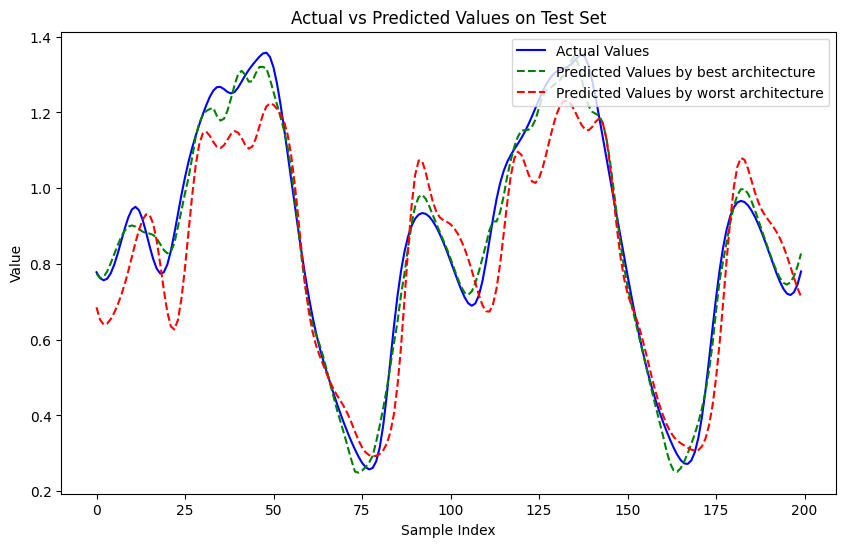

In [ ]:
random_state = 23

# Create MLP model
best_mlp = MLPRegressor(hidden_layer_sizes=(5,4), max_iter=max_iter,
                   learning_rate_init=learning_rate, alpha=weight_decay,
                   n_iter_no_change=n_iter_no_change, random_state=random_state)

worst_mlp = MLPRegressor(hidden_layer_sizes=(4,2), max_iter=max_iter,
                   learning_rate_init=learning_rate, alpha=weight_decay,
                   n_iter_no_change=n_iter_no_change, random_state=random_state)
# Train the model
best_mlp.fit(X_train, y_train)
worst_mlp.fit(X_train, y_train)

# Test the model
best_y_test_pred = best_mlp.predict(X_test)
worst_y_test_pred = worst_mlp.predict(X_test)
print(f'Best Test Error: {mean_squared_error(y_test, best_y_test_pred):.4f}, Worst Test Error: {mean_squared_error(y_test, worst_y_test_pred):.4f}')

# Optional: Plot actual vs predicted values for the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(best_y_test_pred, label='Predicted Values by best architecture', color='green', linestyle='--')
plt.plot(worst_y_test_pred, label='Predicted Values by worst architecture', color='red', linestyle='--')
plt.title('Actual vs Predicted Values on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

Sigma: 0.05, Validation MSE of Arch (5, 3): 0.0017, Arch (5, 6): 0.0092, Arch (5, 9): 0.0024


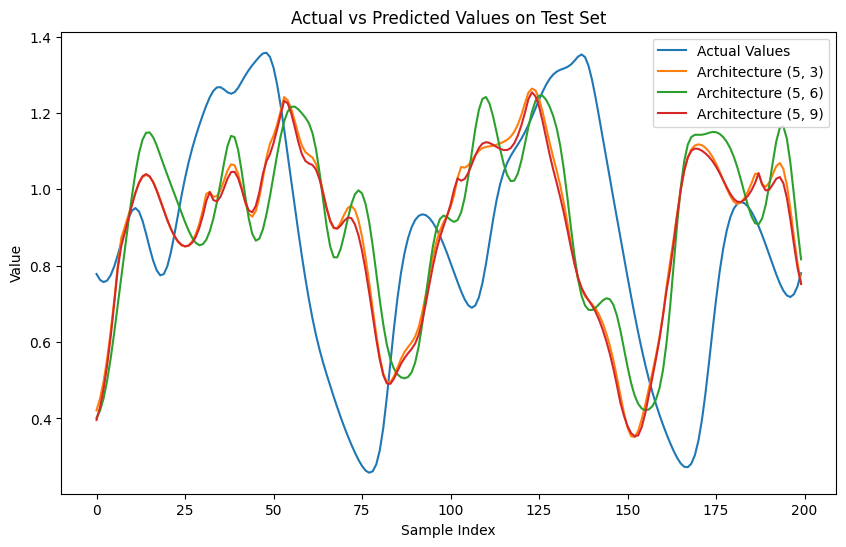

Sigma: 0.15, Validation MSE of Arch (5, 3): 0.0027, Arch (5, 6): 0.0100, Arch (5, 9): 0.0017


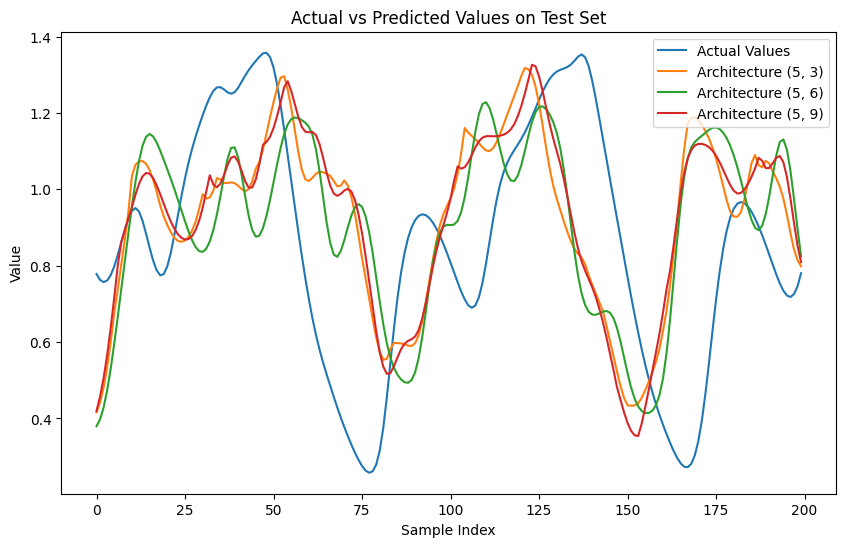

In [ ]:
# Parameters for Gaussian noise
sigma_values = [0.05, 0.15]

# Function to add Gaussian noise to the training targets
def add_noise(y_train, sigma):
    noise = np.random.normal(0, sigma, y_train.shape)
    return y_train + noise

fixed_nh1 = 5  # Number of nodes in the first hidden layer

# Vary number of nodes in the second hidden layer
nh2_options = [3, 6, 9]  # Varying the second hidden layer
for sigma in sigma_values:
    y_preds = []
    y_mses = []
    archs = []

    noisy_y_train = add_noise(y_train, sigma)

    for nh2 in nh2_options:
        arch = (fixed_nh1, nh2)  # Current architecture
        archs.append(arch)
        # Initialize and train the MLP with weight decay (lambda)
        mlp = MLPRegressor(hidden_layer_sizes=arch, max_iter=max_iter,
                   learning_rate_init=learning_rate, alpha=weight_decay,
                   n_iter_no_change=n_iter_no_change, random_state=random_state)

        # Fit the model on noisy training data
        mlp.fit(X_train, noisy_y_train)

        # Validate the model
        y_pred = mlp.predict(X_vali)
        y_mse = mean_squared_error(y_vali, y_pred)
        y_preds.append(y_pred)
        y_mses.append(y_mse)

    print(f'Sigma: {sigma}, Validation MSE of Arch {archs[0]}: {y_mses[0]:.4f}, Arch {archs[1]}: {y_mses[1]:.4f}, Arch {archs[2]}: {y_mses[2]:.4f}')
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual Values')
    plt.plot(y_preds[0], label=f'Architecture {archs[0]}')
    plt.plot(y_preds[1], label=f'Architecture {archs[1]}')
    plt.plot(y_preds[2], label=f'Architecture {archs[2]}')
    plt.title('Actual vs Predicted Values on Test Set')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

4.3.4. Are there any strong trends or particular observations to report? \\
It may worth noting that when node=6, it acts differently from notes=3 or 9, in that the waves of it distribute more evenly, leads to greater loss. So we can say that there may be a 'resonating' between decay and noise, resulting in mediocre pattern learning.

Sigma: 0.05, Validation MSE of Decay 1: 0.0082, Decay 0.1: 0.0016, Decay 0.01: 0.0092


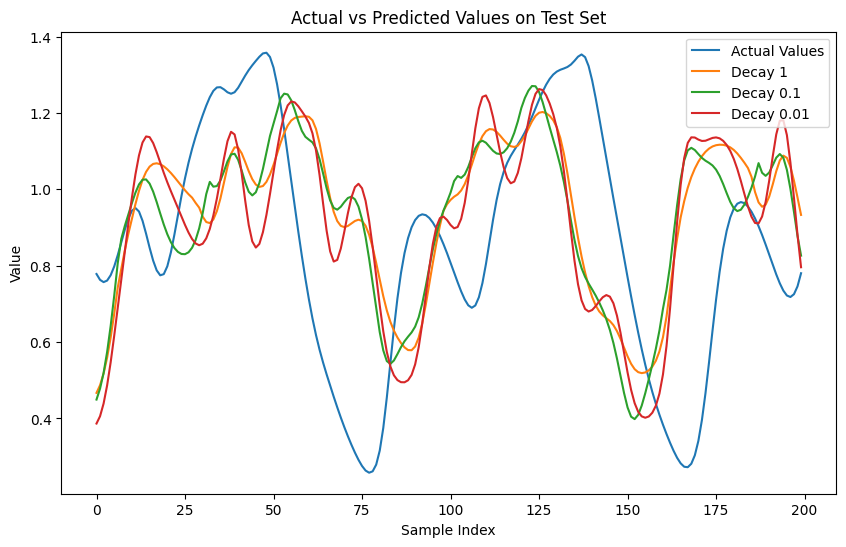

Sigma: 0.15, Validation MSE of Decay 1: 0.0079, Decay 0.1: 0.0042, Decay 0.01: 0.0028


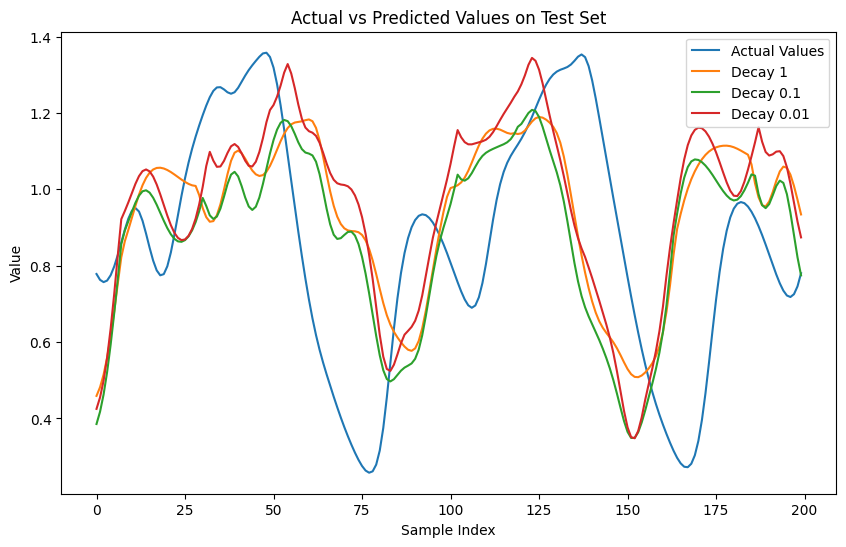

In [ ]:
# Parameters for Gaussian noise
sigma_values = [0.05, 0.15]
decay_values = [1, 0.1, 0.01]

arch = (5, 6)

for sigma in sigma_values:
    y_preds = []
    y_mses = []

    noisy_y_train = add_noise(y_train, sigma)

    for decay in decay_values:
        arch = (fixed_nh1, nh2)  # Current architecture
        archs.append(arch)
        # Initialize and train the MLP with weight decay (lambda)
        mlp = MLPRegressor(hidden_layer_sizes=arch, max_iter=max_iter,
                   learning_rate_init=learning_rate, alpha=decay,
                   n_iter_no_change=n_iter_no_change)

        # Fit the model on noisy training data
        mlp.fit(X_train, noisy_y_train)

        # Validate the model
        y_pred = mlp.predict(X_vali)
        y_mse = mean_squared_error(y_vali, y_pred)
        y_preds.append(y_pred)
        y_mses.append(y_mse)

    print(f'Sigma: {sigma}, Validation MSE of Decay {decay_values[0]}: {y_mses[0]:.4f}, Decay {decay_values[1]}: {y_mses[1]:.4f}, Decay {decay_values[2]}: {y_mses[2]:.4f}')
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual Values')
    plt.plot(y_preds[0], label=f'Decay {decay_values[0]}')
    plt.plot(y_preds[1], label=f'Decay {decay_values[1]}')
    plt.plot(y_preds[2], label=f'Decay {decay_values[2]}')
    plt.title('Actual vs Predicted Values on Test Set')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

Still there is no obvious pattern, except that grater weight decay leads to more obtuse crest.

4.3.5 Another hyperparameter tunning task. I don't think it's inspirational.